### Импорт библиотек

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import leidenalg
import igraph as ig
from collections import defaultdict
from collections import Counter
import numpy as np
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import pandas as pd

/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Испорт функций

In [2]:
from src.funcs.simple_classifier_funcs import get_embeddings, train_graph_randomforestclassifier, train_graph_randomforestclassifier2

### Обработка графа
Загружаем данные и удаляем самую большую компоненту

In [3]:
import os
os.chdir('../..')

In [21]:
# filename = 'data/graph_full.txt'
filename = 'data/graph_collapse.txt'

G = nx.Graph()

with open(filename, 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(node1, node2)

df = pd.read_csv('data/graph_collapse_node_traits_2.txt', delimiter='\t')

node_family_dict = df.set_index('node')['fam'].to_dict()
node_freq_dict = df.set_index('node')['freq'].to_dict()
unique_fams = set(node_family_dict.values())
print(f"Number of unique families: {len(unique_fams)}")

# Удаление самой большой компоненты связности
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
for node in largest_component:
    G.remove_node(node)
print(f"Number of components: {len(components) - 1}")

Number of unique families: 14
Number of components: 759


### Получаем эмбеддинги

In [5]:
# families = ['DNA/HAT', 'DNA/MuDR', 'Helitron', 'LINE', 'LTR/Copia']
families = ['Helitron', 'LINE', 'DNA/MuDR']
G_not_full = G.copy()
for node in G.nodes():
    if node_family_dict[node] not in families:
        G_not_full.remove_node(node)

In [6]:
import pickle
# Проверяем, существует ли файл с эмбеддингами
file_path = 'data/node2vec_embeddings3.pkl'
if os.path.exists(file_path):
    # Если файл существует, загружаем эмбеддинги из файла
    print("Чтение...")
    with open(file_path, "rb") as f:
        node_embeddings = pickle.load(f)
else:
    # Если файл отсутствует, генерируем эмбеддинги
    node_embeddings = get_embeddings(G_not_full, 50)
    # Сохраняем эмбеддинги в файл
    print("Сохранение...")
    with open(file_path, 'wb') as f:  
        pickle.dump(node_embeddings, f)
print("Завершено")


Чтение...
Завершено


#### Сохраняем эмбеддинги

In [7]:
import pickle
# Проверяем, существует ли файл с эмбеддингами
file_path = 'data/node2vec_embeddings4.pkl'
if os.path.exists(file_path):
    # Если файл существует, загружаем эмбеддинги из файла
    print("Чтение...")
    with open(file_path, "rb") as f:
        node_embeddings2 = pickle.load(f)
else:
    # Если файл отсутствует, генерируем эмбеддинги
    node_embeddings2 = get_embeddings(G_not_full, 50)
    # Сохраняем эмбеддинги в файл
    print("Сохранение...")
    with open(file_path, 'wb') as f:  
        pickle.dump(node_embeddings2, f)
print("Завершено")


Чтение...
Завершено


### Обучаем модель

In [8]:
node_embeddings2

{'N928': array([-0.01857365, -0.00838647, -0.00022664,  0.0096511 ,  0.01597482,
         0.00379434,  0.01389699,  0.00833998, -0.00126874, -0.00321368,
        -0.00581912,  0.01328839, -0.01510266, -0.01301231, -0.01869894,
        -0.00250822, -0.00297285, -0.01987798, -0.01411896,  0.01571833,
         0.01974318, -0.00503287, -0.00794545,  0.00541727,  0.0181447 ,
        -0.01726747,  0.0100163 ,  0.00755855,  0.01786186,  0.01271777,
        -0.01970239,  0.0106612 ,  0.01335194, -0.01977964, -0.01620208,
        -0.01268321,  0.00056236,  0.01015895, -0.01785892,  0.0039755 ,
        -0.00919731,  0.01430176,  0.00853144, -0.01526287, -0.00829648,
        -0.00199048,  0.00839964,  0.00122225, -0.01851046,  0.01098428],
       dtype=float32),
 'N26': array([ 0.5418477 ,  1.0023363 ,  0.5850265 , -0.66513467, -0.5201926 ,
         0.43509722, -0.1563235 ,  1.3538195 , -0.3923379 ,  0.19794276,
        -0.88971066, -0.2865052 ,  0.7612656 ,  0.6836349 ,  0.07712912,
        -0.0

In [9]:
clf = train_graph_randomforestclassifier2(G_not_full, node_embeddings, node_embeddings2, node_family_dict)

75


TypeError: unsupported operand type(s) for /=: 'NoneType' and 'int'

In [10]:
G = G_not_full

In [11]:
# Определение класса для каждой компоненты
remaining_components = list(nx.connected_components(G))
component_classes = []
component_nodes = []

for component in remaining_components:
    if len(component) < 4:
        continue
    families = [node_family_dict[node] for node in component if
                node in node_family_dict and not pd.isna(node_family_dict[node])]
    if families:
        # Определение класса компоненты
        most_common_class = Counter(families).most_common(1)[0][0]
        component_classes.append(most_common_class)
        component_nodes.append(component)
print(len(component_nodes))


75


In [12]:
families = ['Helitron', 'LINE', 'DNA/MuDR']
colors = plt.get_cmap('tab20', len(families))
fam_to_color = {cls: colors(i) for i, cls in enumerate(families)}
node_colors = [fam_to_color[node_family_dict[node]] for node in G_not_full.nodes]

In [13]:
fam_to_color

{'Helitron': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'LINE': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 'DNA/MuDR': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)}

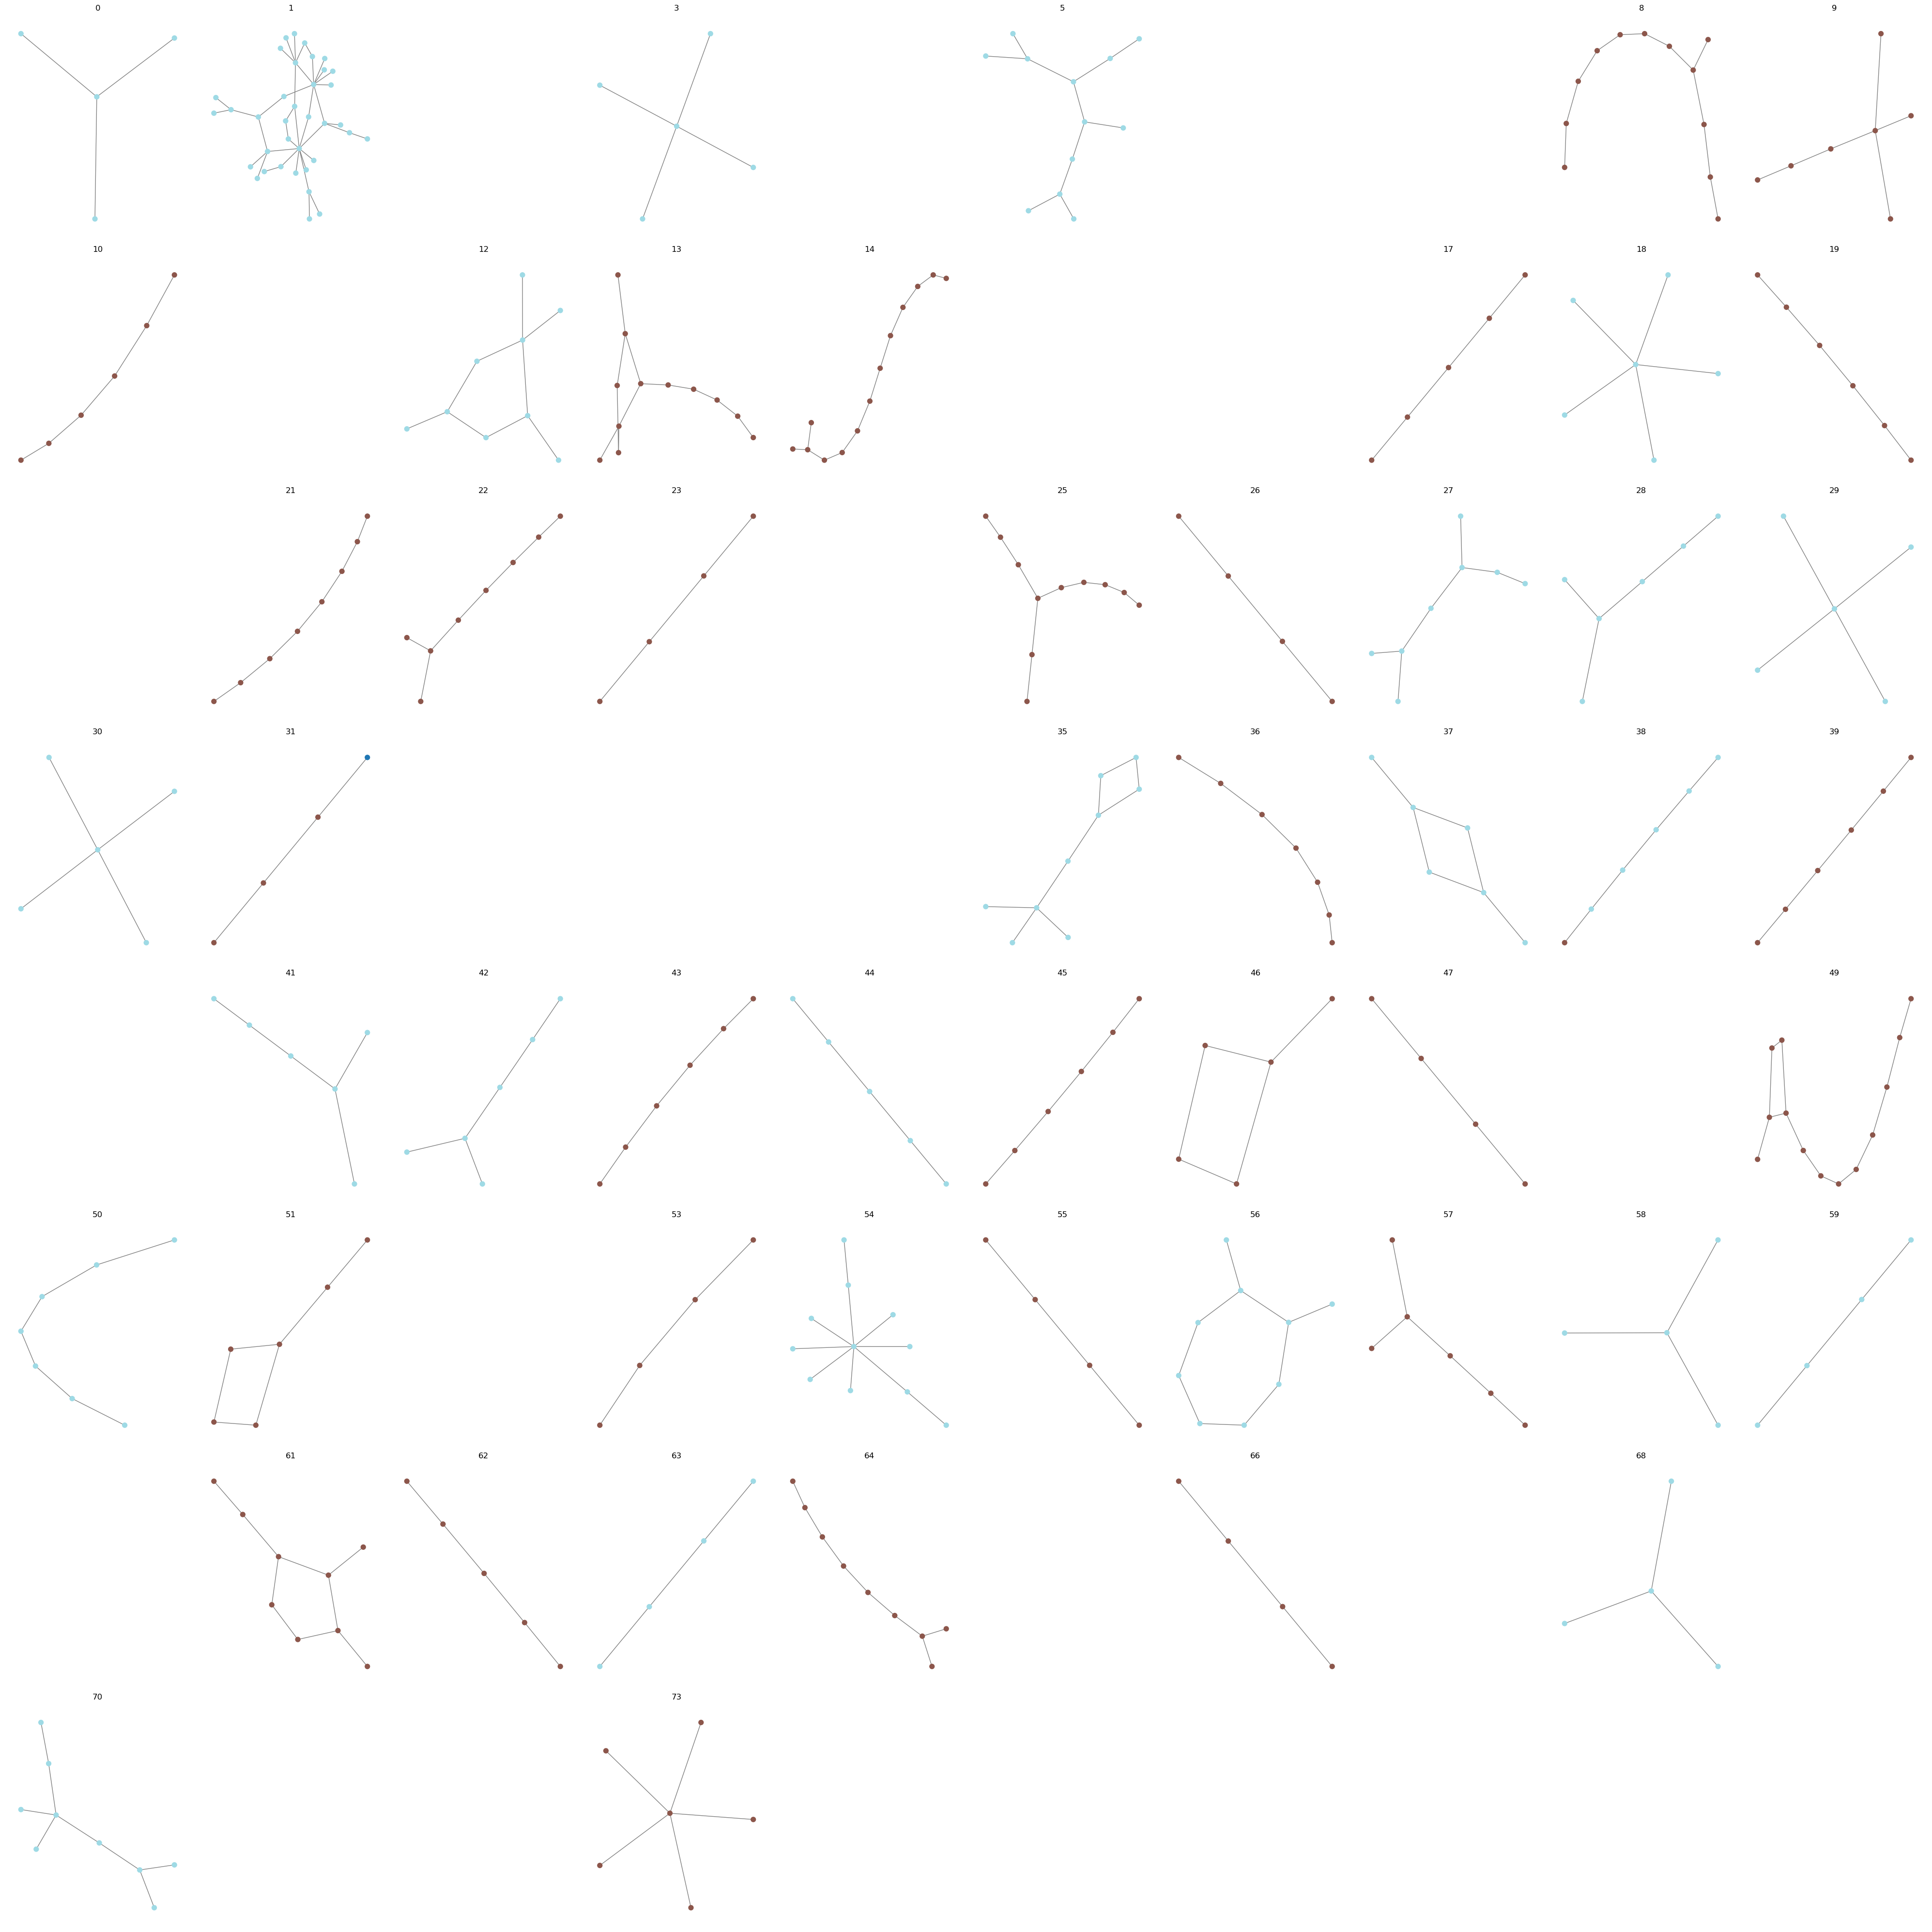

In [14]:
num_clusters = len(component_classes)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))
highlighted_node = "SVgr_3_id_50111|2794"

for i, cluster_nodes in enumerate(component_nodes):
    if component_classes[i] == 'Helitron':
        continue
    # print(cluster_nodes)
    plt.subplot(rows, cols, i + 1)
    G_sub = G_not_full.subgraph(cluster_nodes).copy()
    # print(len(G_sub.nodes))
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    
    
    if highlighted_node in G_sub.nodes:
        node_colors_sub = [
            'red' if node == highlighted_node else node_colors_sub[j]
            for j, node in enumerate(G_sub.nodes)
        ]
        node_sizes_sub = [
            200 if node == highlighted_node else 50
            for node in G_sub.nodes
        ]
        print('found', i)
    else:
        node_sizes_sub = [50] * len(G_sub.nodes)
        
        
        
    nx.draw(
        G_sub, 
        pos, 
        with_labels=False, 
        node_color=node_colors_sub, 
        edge_color='gray', 
        node_size=node_sizes_sub, 
        font_size=1
    )
    plt.title(i)

plt.tight_layout()
plt.show()

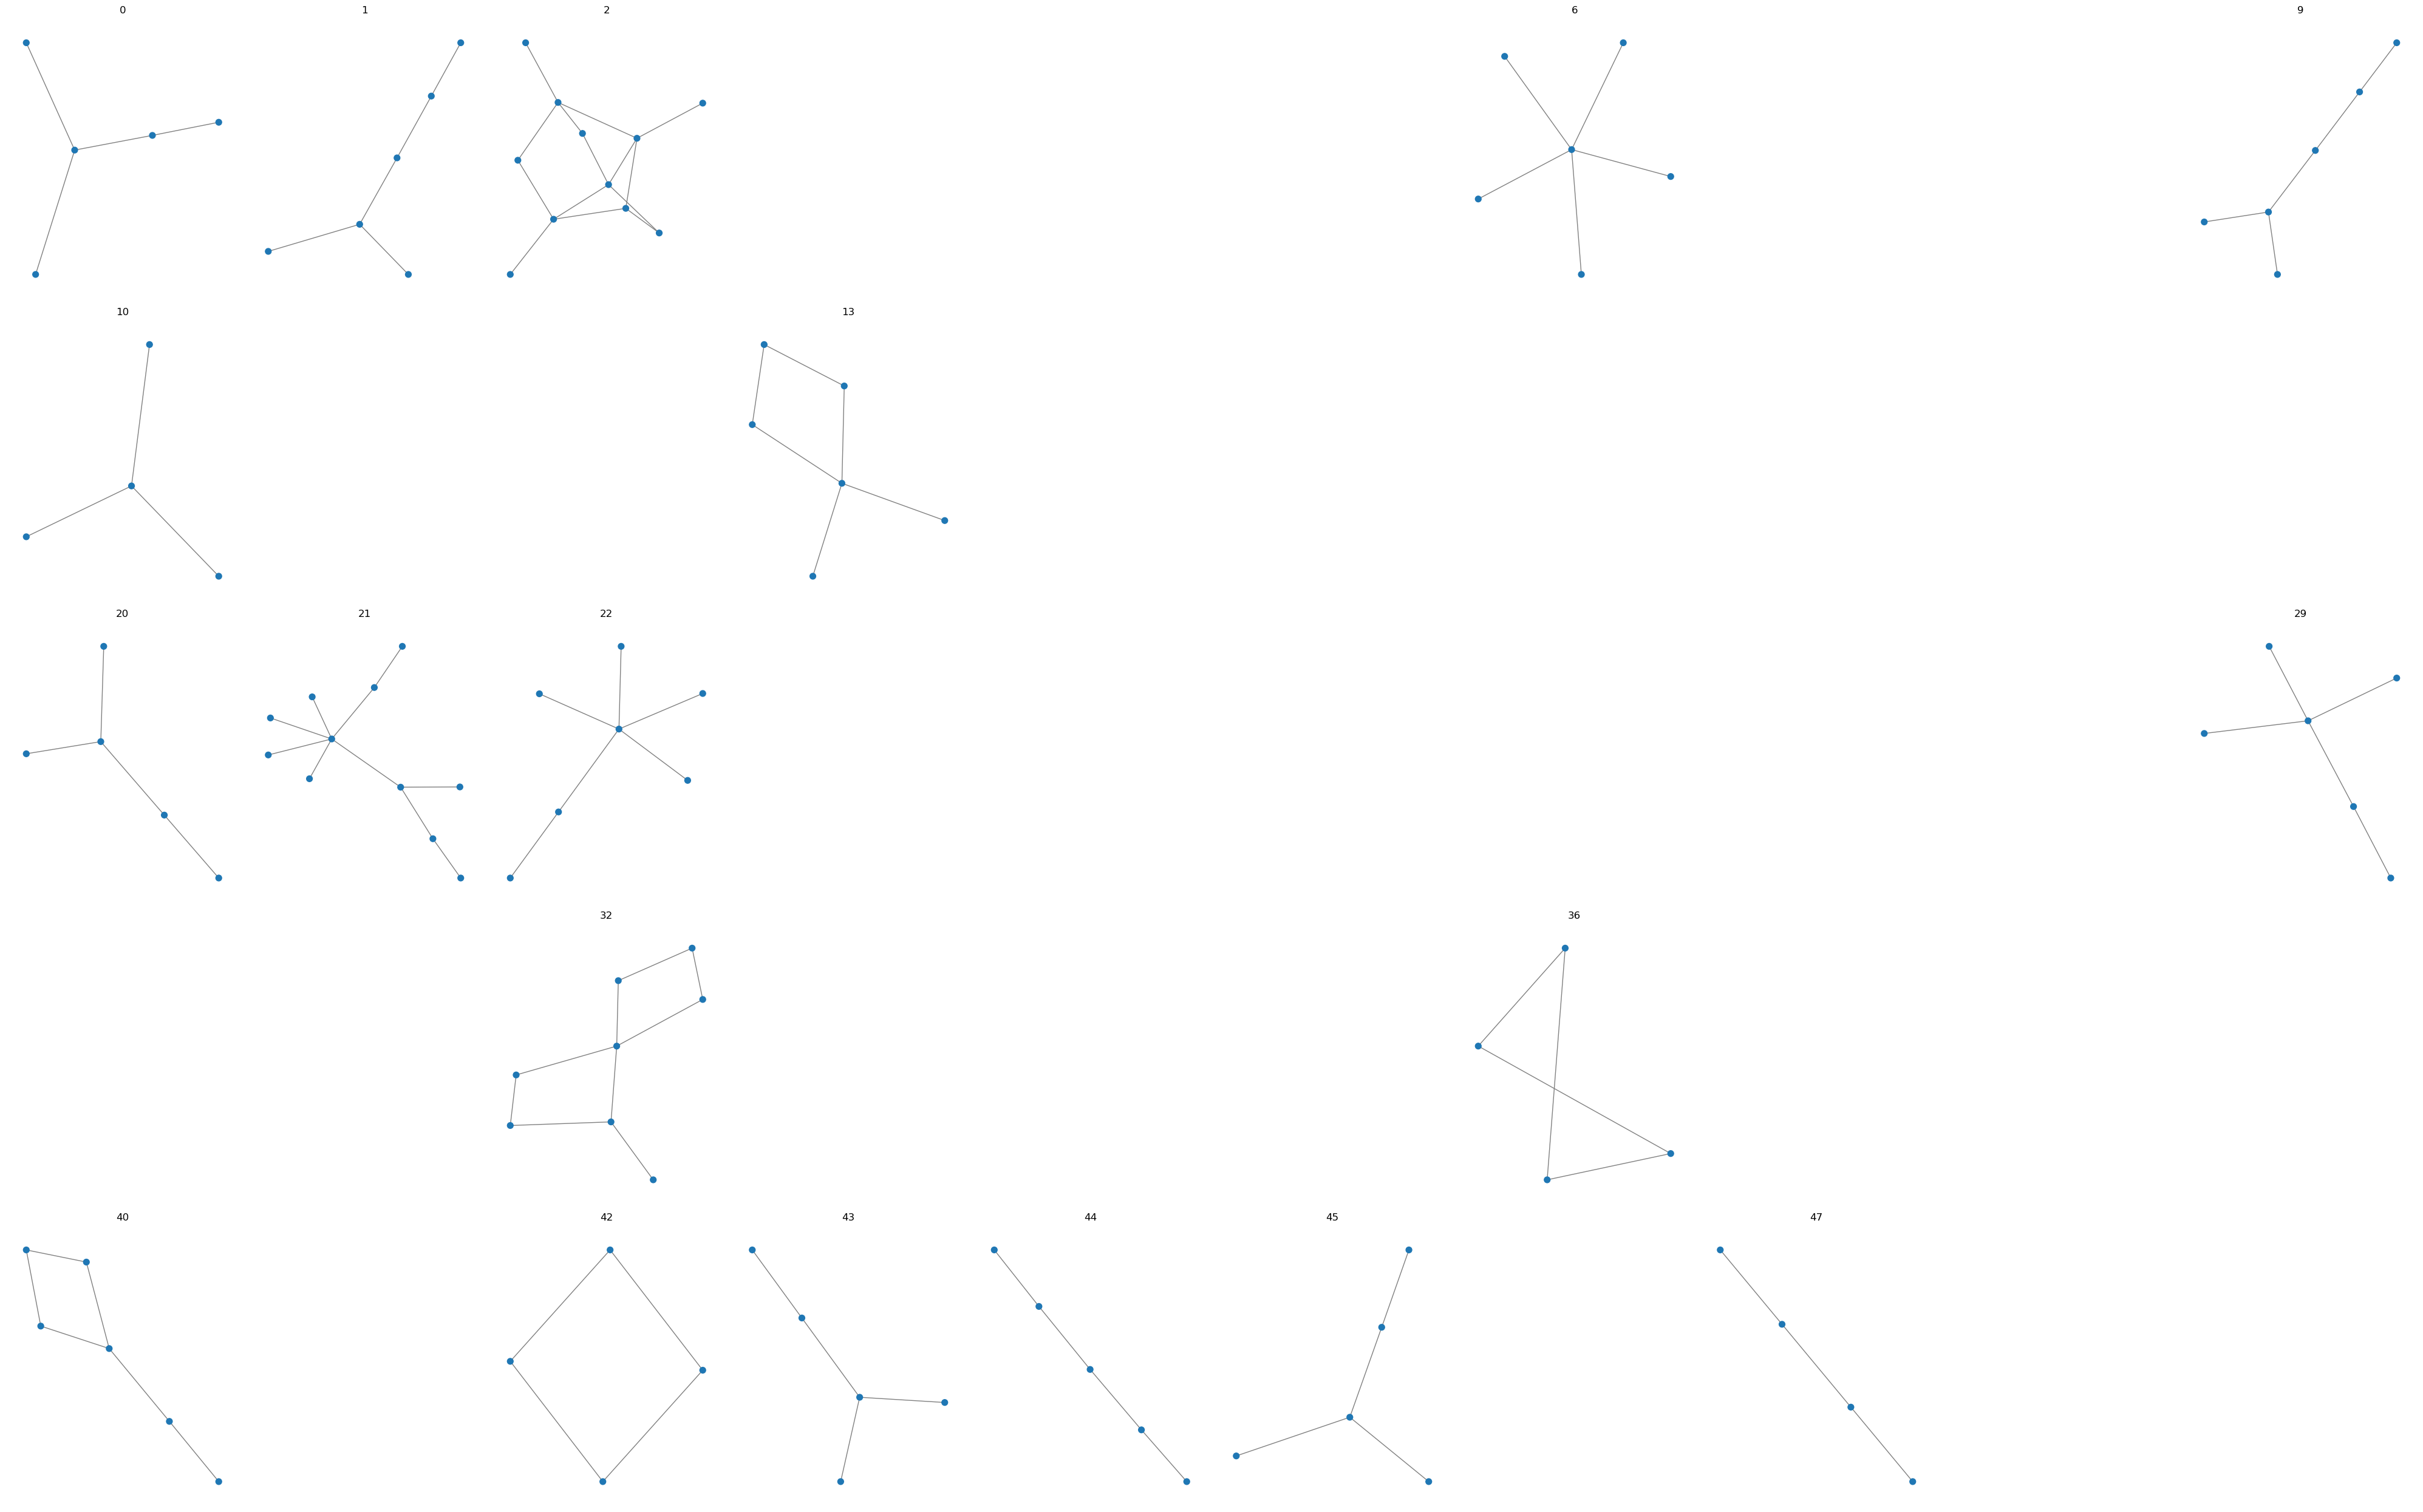

In [43]:
num_clusters = len(component_classes)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))
highlighted_node = "SVgr_3_id_50111|2794"

for i, cluster_nodes in enumerate(component_nodes):
    if component_classes[i] == 'LINE':
        continue
    # print(cluster_nodes)
    plt.subplot(rows, cols, i + 1)
    G_sub = G_not_full.subgraph(cluster_nodes).copy()
    # print(len(G_sub.nodes))
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    
    
    if highlighted_node in G_sub.nodes:
        node_colors_sub = [
            'red' if node == highlighted_node else node_colors_sub[j]
            for j, node in enumerate(G_sub.nodes)
        ]
        node_sizes_sub = [
            200 if node == highlighted_node else 50
            for node in G_sub.nodes
        ]
        print('found', i)
    else:
        node_sizes_sub = [50] * len(G_sub.nodes)
        
        
        
    nx.draw(
        G_sub, 
        pos, 
        with_labels=False, 
        node_color=node_colors_sub, 
        edge_color='gray', 
        node_size=node_sizes_sub, 
        font_size=1
    )
    plt.title(i)

plt.tight_layout()
plt.show()

In [15]:
len(component_nodes[30])

5

Text(0.5, 1.0, 'DNA/MuDR')

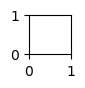

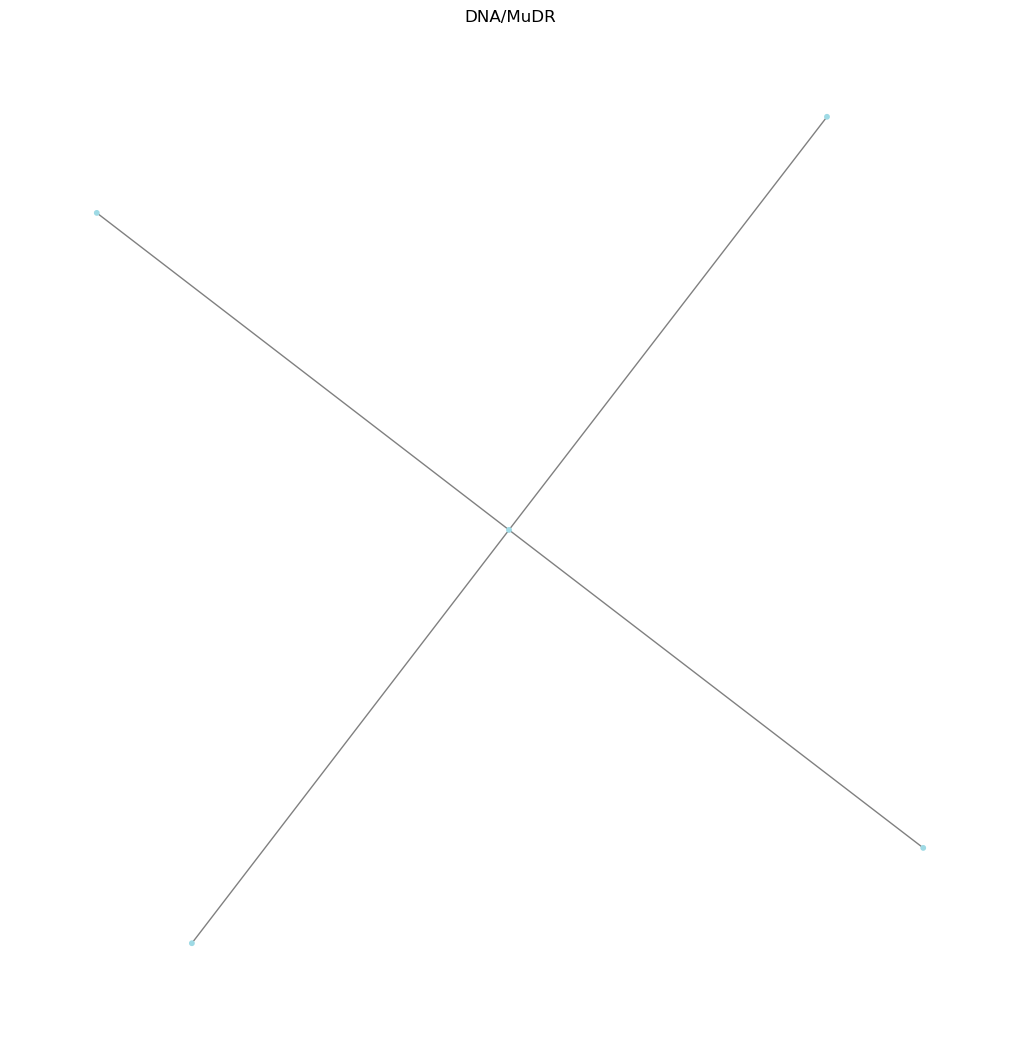

In [16]:
i = 30
cluster_nodes = component_nodes[30]
plt.subplot(rows, cols, i + 1)
G_sub = G_not_full.subgraph(cluster_nodes).copy()
# print(len(G_sub.nodes))
pos = nx.spring_layout(G_sub)
node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]


if highlighted_node in G_sub.nodes:
    node_colors_sub = [
        'red' if node == highlighted_node else node_colors_sub[j]
        for j, node in enumerate(G_sub.nodes)
    ]
    node_sizes_sub = [
        20 if node == highlighted_node else 10
        for node in G_sub.nodes
    ]
    print('found', i)
else:
    node_sizes_sub = [10] * len(G_sub.nodes)
    
    
plt.figure(figsize=(10, 10)) 
nx.draw(
    G_sub, 
    pos, 
    with_labels=False, 
    node_color=node_colors_sub, 
    edge_color='gray', 
    node_size=node_sizes_sub, 
    font_size=1
)
plt.title(component_classes[i])

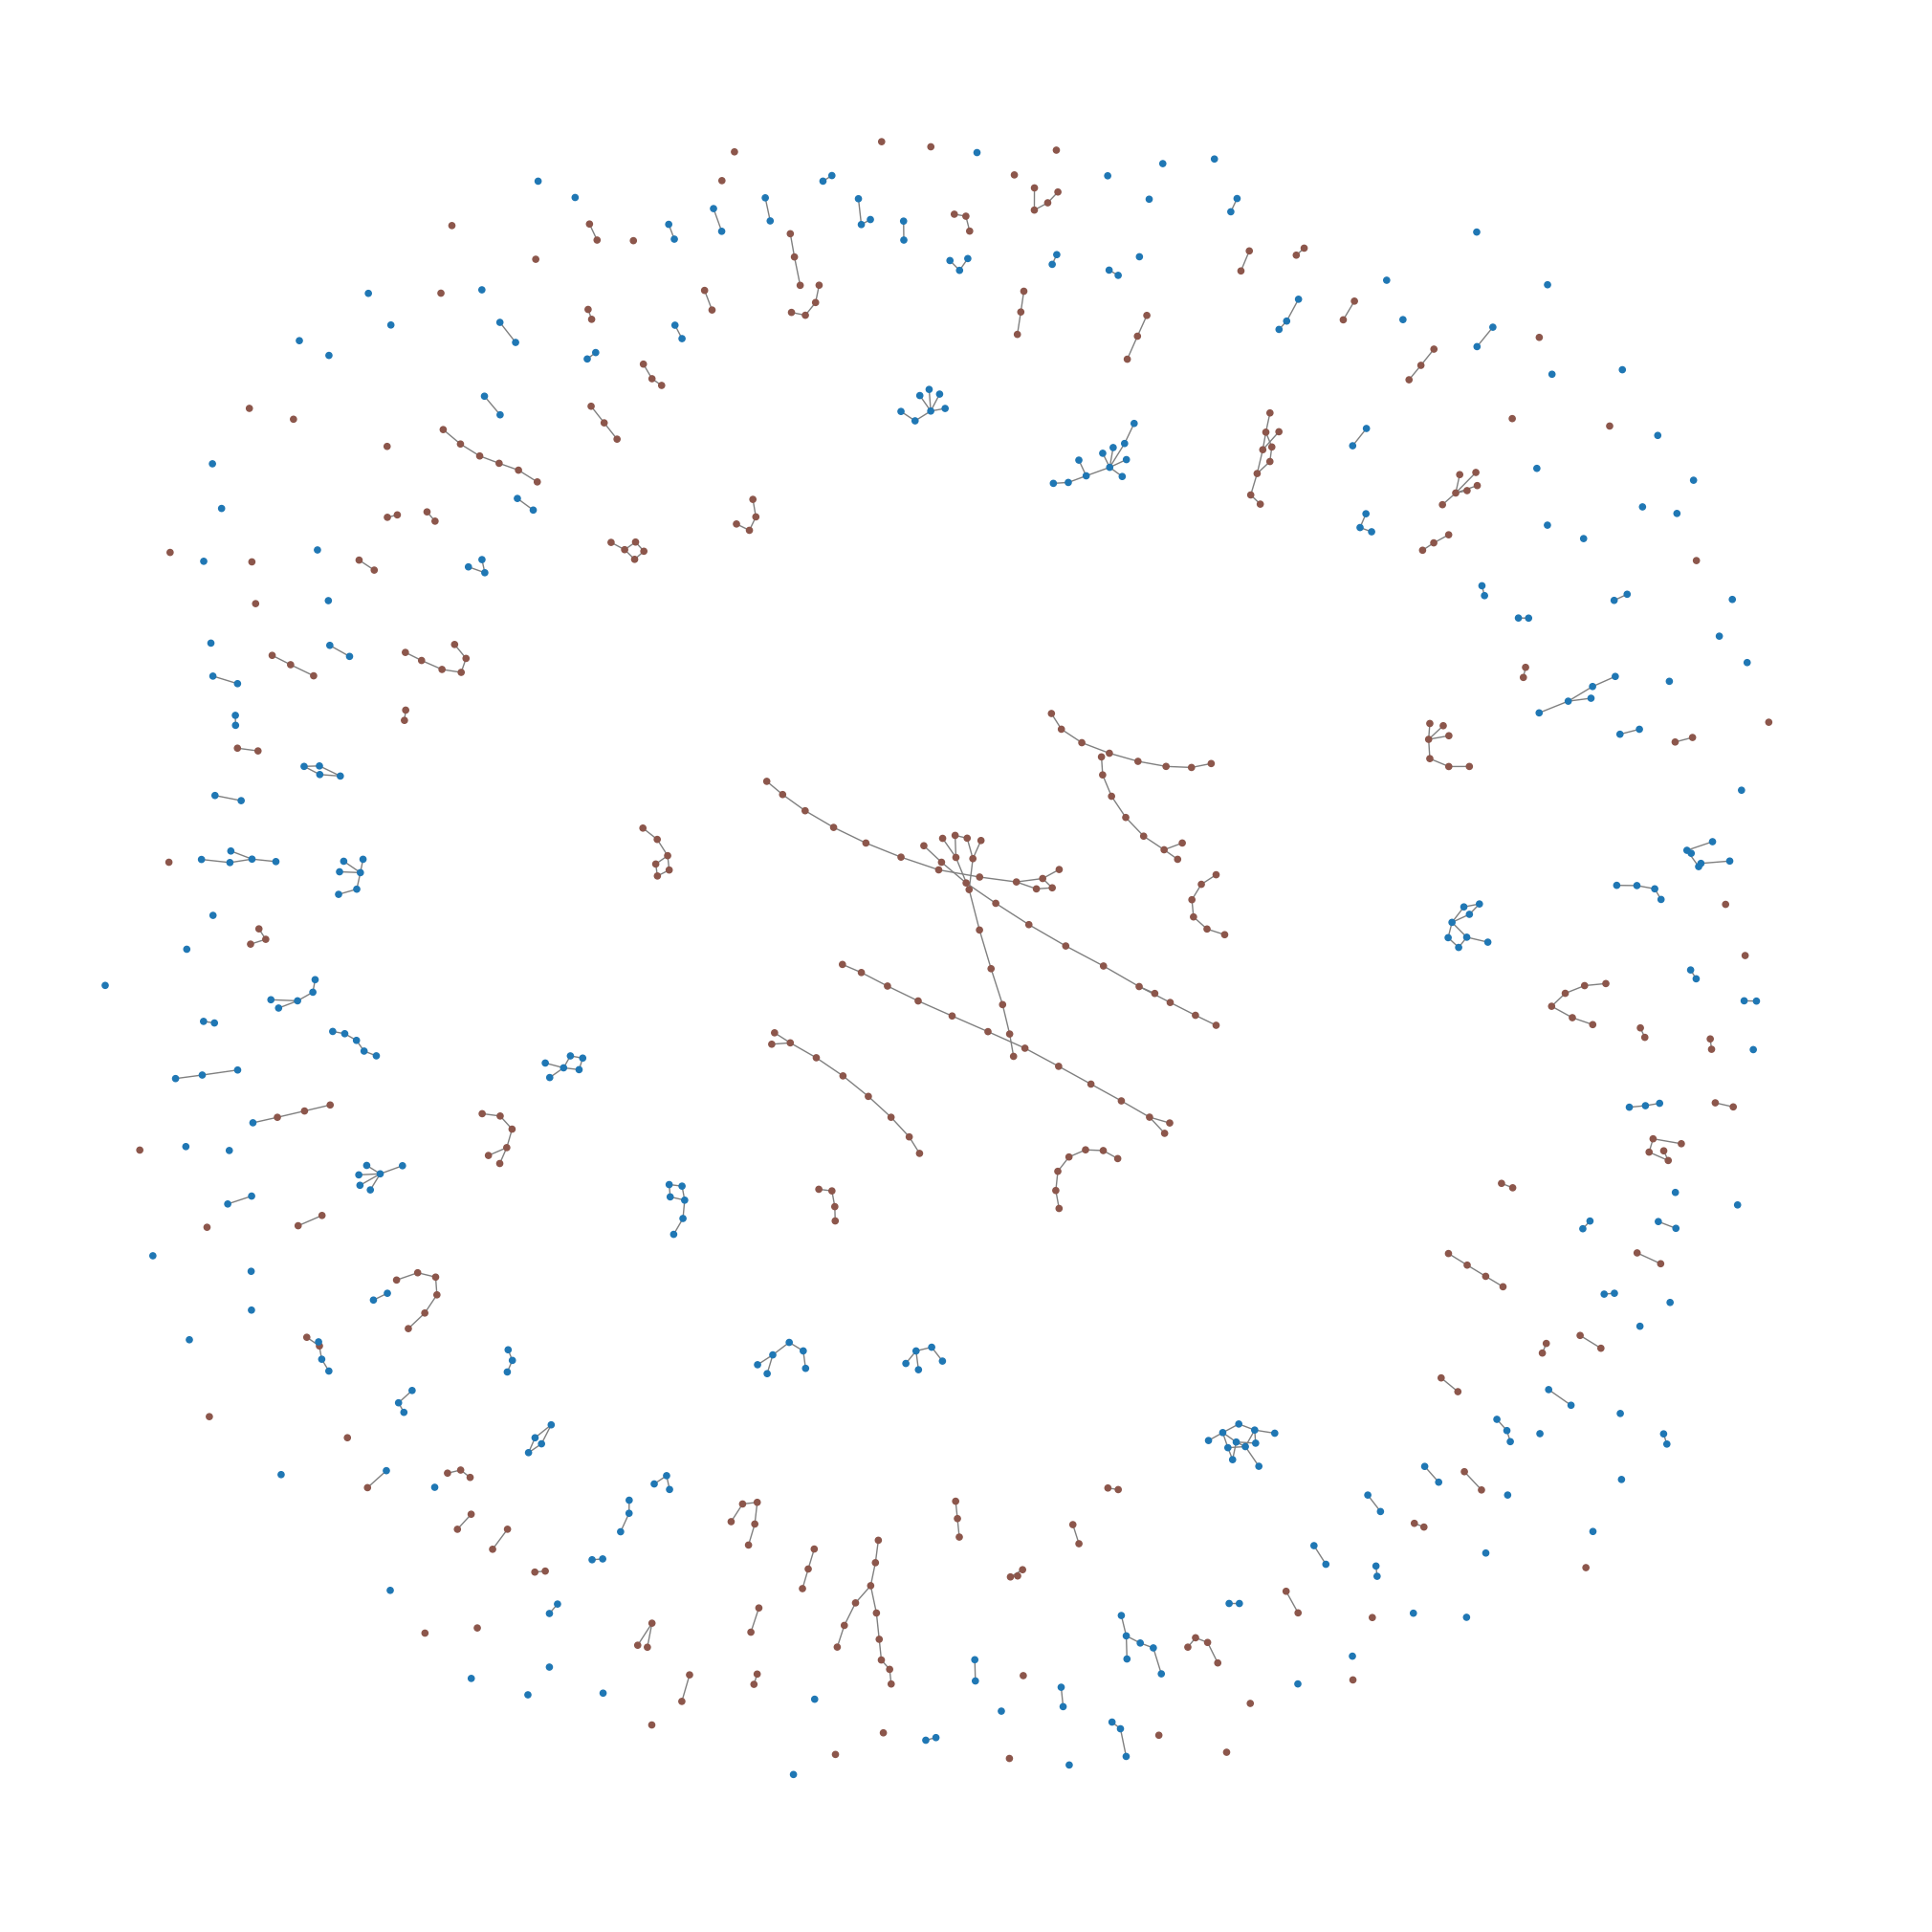

In [46]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_not_full)
nx.draw(G_not_full, pos, with_labels=False, node_color=node_colors, edge_color='gray', node_size=20, font_size=1)

plt.show()
        

In [59]:
# Создание набора данных на уровне узлов
X, y = [], []

for component, component_label in zip(component_nodes, component_classes):
    G_sub = G_not_full.subgraph(component).copy()
    degrees = [deg for _, deg in G_sub.degree()]
    mean_degree = sum(degrees) / len(degrees) if len(degrees) > 0 else 0
    
    number_nodes = len(G_sub.nodes())
    
    max_degrees = sorted(degrees)[:3]
    
    # max_freq = max([node_freq_dict[node] for node in list(G_sub.nodes())])
    
    freqs = sorted([node_freq_dict[node] for node in list(G_sub.nodes())])[:3]
    
    # node_with_max_freq = max((node for node in node_freq_dict if node in G_sub.nodes()), key=node_freq_dict.get, default=None)

    
    # degree_of_node_with_max_freq = G_sub.degree(node_with_max_freq)
    
    embedding = [mean_degree, number_nodes] + max_degrees + freqs
    X.append(embedding)  # Добавляем эмбеддинги узла
    y.append(component_label)  # Метка компоненты


In [60]:
X

[[1.5, 4, 1, 1, 1, 1, 2, 26],
 [2.2222222222222223, 36, 1, 1, 1, 1, 1, 1],
 [1.6, 5, 1, 1, 1, 1, 1, 2],
 [1.6, 5, 1, 1, 1, 1, 1, 3],
 [1.7142857142857142, 7, 1, 1, 1, 4, 4, 5],
 [1.8333333333333333, 12, 1, 1, 1, 1, 3, 3],
 [2.2222222222222223, 9, 1, 1, 1, 1, 1, 4],
 [2.5454545454545454, 11, 1, 1, 1, 1, 1, 1],
 [1.8333333333333333, 12, 1, 1, 1, 1, 1, 1],
 [1.7142857142857142, 7, 1, 1, 1, 1, 1, 1],
 [1.6666666666666667, 6, 1, 1, 2, 1, 1, 2],
 [1.6666666666666667, 6, 1, 1, 1, 1, 1, 1],
 [2.0, 9, 1, 1, 1, 1, 1, 1],
 [2.0, 12, 1, 1, 1, 1, 1, 1],
 [1.8461538461538463, 13, 1, 1, 1, 1, 1, 1],
 [1.6666666666666667, 6, 1, 1, 1, 1, 1, 1],
 [1.5, 4, 1, 1, 1, 1, 1, 3],
 [1.6, 5, 1, 1, 2, 1, 1, 2],
 [1.6666666666666667, 6, 1, 1, 1, 1, 7, 25],
 [1.6666666666666667, 6, 1, 1, 2, 1, 2, 2],
 [2.0, 6, 1, 1, 2, 1, 2, 2],
 [1.75, 8, 1, 1, 2, 1, 1, 1],
 [1.75, 8, 1, 1, 1, 1, 1, 1],
 [1.5, 4, 1, 1, 2, 1, 1, 1],
 [1.5, 4, 1, 1, 2, 3, 3, 3],
 [1.8181818181818181, 11, 1, 1, 1, 1, 1, 1],
 [1.5, 4, 1, 1, 2, 1, 1, 

In [61]:
class_mapping = {original: encoded for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}
class_mapping

{'DNA/MuDR': 0, 'Helitron': 1, 'LINE': 2}

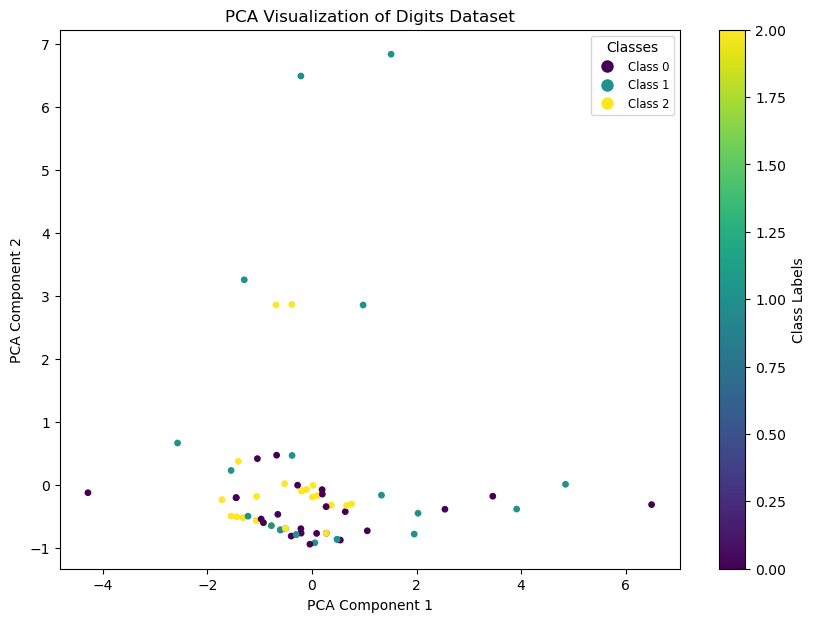

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

# 2. Преобразование строковых меток в числа
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Labels')
plt.title("PCA Visualization of Digits Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
unique_classes = np.unique(y_encoded)
class_colors = scatter.cmap(scatter.norm(unique_classes))

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Class {cls}', 
           markerfacecolor=class_colors[i], markersize=10)
    for i, cls in enumerate(unique_classes)
]
plt.legend(handles=legend_elements, title="Classes", loc="best", fontsize="small")

plt.show()


In [35]:
len(y_encoded)

1797

/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


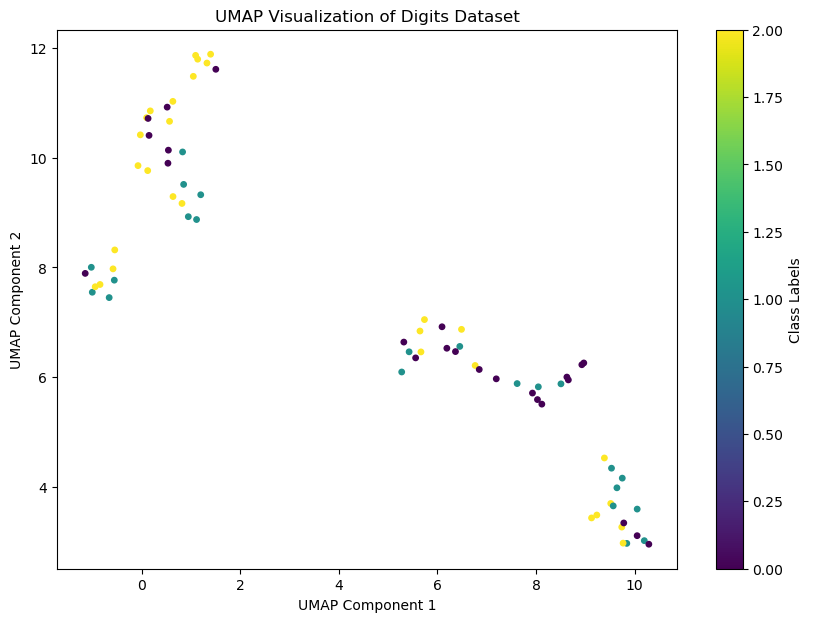

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_encoded, cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Labels')
plt.title("UMAP Visualization of Digits Dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


In [28]:
y_encoded[22], y_encoded[23]

(0, 1)

In [26]:
X_embedded

array([[ -552.9805  ,   632.3645  ],
       [ 1192.9354  ,  -306.37616 ],
       [ -300.1918  ,    -9.911756],
       [ -300.1918  ,    -9.911756],
       [ -323.32443 ,   338.3406  ],
       [ -869.5668  ,  -768.56055 ],
       [ -267.15048 ,  -859.5788  ],
       [ -216.05862 , -1070.2937  ],
       [ -869.5668  ,  -768.56055 ],
       [ -323.32443 ,   338.3406  ],
       [  608.75214 ,   218.57764 ],
       [ -667.71826 ,   172.7319  ],
       [ -501.0747  ,  -702.69586 ],
       [ -238.88387 ,  -590.19586 ],
       [-1078.9218  ,  -541.6333  ],
       [ -667.71826 ,   172.7319  ],
       [ -552.9805  ,   632.3645  ],
       [  299.0487  ,   391.6688  ],
       [ -667.71826 ,   172.7319  ],
       [  608.75214 ,   218.57764 ],
       [  439.19696 ,  -328.73416 ],
       [  439.52832 ,   -52.667965],
       [ -630.3503  ,  -229.81453 ],
       [  572.41064 ,   691.3052  ],
       [  572.41064 ,   691.3052  ],
       [ -789.54614 ,  -500.96674 ],
       [  572.41064 ,   691.3052  ],
 

In [29]:
unique_rows = np.unique(X_embedded, axis=0)
print(unique_rows)

[[-1132.5485      97.066475]
 [-1117.4122    -274.88846 ]
 [-1045.9337     815.40674 ]
 [ -817.2601     309.1452  ]
 [ -672.53986    -93.841064]
 [ -591.9847    -693.8694  ]
 [ -473.5204     904.1685  ]
 [ -359.05612    394.3241  ]
 [ -304.06967   -286.76755 ]
 [ -142.92386   1332.0011  ]
 [  -67.87037   -844.4268  ]
 [   90.29983    791.13214 ]
 [   94.5691    -287.9993  ]
 [  100.34966    336.4209  ]
 [  287.5684    1284.6562  ]
 [  372.61954   -501.98227 ]
 [  450.7941      32.997627]
 [  570.96155    477.69397 ]
 [  578.71545    888.6863  ]
 [  761.46466   -287.1102  ]
 [ 1036.2455     327.99142 ]
 [ 1255.9913     -55.545017]
 [ 1262.618     -415.77725 ]]


In [28]:
np.array(X_train).shape

(52, 5)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Обучение классификатора
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Результат
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

data = pd.DataFrame({'Array1': y_test, 'Array2': y_pred})

# Создание таблицы сопряжённости
contingency_table = pd.crosstab(data['Array1'], data['Array2'])

print(contingency_table)

              precision    recall  f1-score   support

    DNA/MuDR       0.45      0.56      0.50         9
    Helitron       0.67      0.33      0.44         6
        LINE       0.44      0.50      0.47         8

    accuracy                           0.48        23
   macro avg       0.52      0.46      0.47        23
weighted avg       0.51      0.48      0.48        23

Array2    DNA/MuDR  Helitron  LINE
Array1                            
DNA/MuDR         5         0     4
Helitron         3         2     1
LINE             3         1     4
